In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Assignment 2

## Task 2.1

First I do the same as in assignment 1: defines a arbitrary polynomial model. 




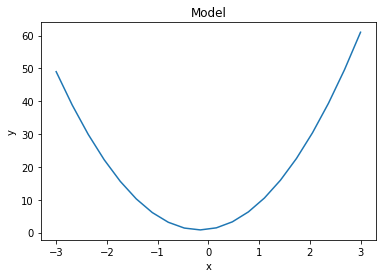

In [85]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model

# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = [1,2,6]
y_model = arbitrary_poly(true_params)

# Plot true model
x = np.linspace(start=-3, stop=3, num=20)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model");

### Then I generate the noise measurements with gaussian distribution:

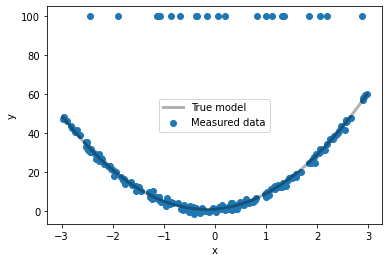

In [91]:
# Hyperparameters for the type of noise-generating distribution.
loc = 0           # location (mean) parameter 
scale = 1         # scaling (std dev) parameter
magnitude = 1.2   # noise magnitude
N = 201          # number of samples

np.random.seed(123)  # Non-random generation between code executions. Comment out for true random

# Generate data points
range_low = -3
range_high = 3
u = np.sort(np.random.uniform(range_low,range_high,N))
y_true = y_model(u)


# Generate noisez
from scipy.stats import norm, laplace

normVariance = 1 # Input as the scale parameter in the normal distribution

laplaceVariance = 1

alfa = 0

gamma = 0.1

noiseNorm = magnitude * np.random.normal(loc, normVariance, int(alfa * N*(1-gamma)))

noiseLaplace = magnitude * np.random.laplace(loc, laplaceVariance, int((1-alfa)*N*(1-gamma)))

faultyMeasurement = np.full(int(N*gamma), 100) 

NoiseFault = np.concatenate((noise, faultyMeasurement))

np.random.shuffle(NoiseFault)

# Add noise to the generated data points - thus simulating measurement

y = y_true

for i in range(0, N-1):
    if NoiseFault[i] == 100:
        y[i] = NoiseFault[i]
    else:
        y[i] = y_true[i] + NoiseFault[i]

# Plot measured data
plt.scatter(u, y, label=r"Measured data")
u0 = np.linspace(min(u), max(u), N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

## Task 2.3

### LS:



In [176]:
# Matrix form
u_tensor_0 = np.reshape(u,(N,1))

ones_vec = np.ones((N,1))
u_tensor = np.append(ones_vec, u_tensor_0, axis=1)

for i in range(2,len(true_params)):
    u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)

u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse

u_transpose_dot_y = np.dot(u_tensor.T,y)  # calculating dot product


LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
LS_params_rounded = ["{:.2f}".format(round(i, 2)) for i in LS_params.tolist()]
print(f"LS parameters:         {LS_params_rounded}")
print(f"True model parameters: {true_params}")

diffParams = []
for i in range(0, len(true_params)):
    diffParams.append(float(true_params[i] - float(LS_params_rounded[i])))

print("The differnence between the estimated theata and the real Theta is: " {diffParams})

# Recreate model based on LS estimate:
LS_params = LS_params.tolist()
LS_estimate = arbitrary_poly(LS_params)

# Plot true vs. estimated model
plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
u0 = np.linspace(min(u), max(u), N)
plt.plot(u0, y_model(u0), "g", alpha=0.7, lw=3, label="True model")
plt.plot(u0, LS_estimate(u0), "r--",  lw=3, label="LS estimate")
#plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

SyntaxError: invalid syntax (<ipython-input-176-6ee73ce1891b>, line 25)

## ML:


### Function for calculating the log likelihood function: 

In [113]:
def log_lik(par_vec, y, x):
    global pdf  # Use the distribution class chosen earlier
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
              loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale = par_vec[-1])
    
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

### Function for calculating the MLE:

In [175]:
def MLEfunction(order, pdf):

    import scipy.optimize as optimize

    # The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
    # therefore the initial guess verctor has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
    init_guess = np.zeros(order+1)
    init_guess[-1] = N

    # Do Maximum Likelihood Estimation:
    opt_res = optimize.minimize(fun = log_lik,
                                x0 = init_guess,
                                options={'disp': False},
                                args = (y, u))

    MLE_params = opt_res.x[:-1]
    MLE_estimate = arbitrary_poly(MLE_params)

    MLE_params_rounded = ["{:.2f}".format(round(i, 2)) for i in MLE_params.tolist()]
    print(f"\nMLE parameters of order :      {MLE_params_rounded}")

    return MLE_estimate

    

### Calculating ML for differnt orders:


MLE parameters of order 1:      ['13.20']

MLE parameters of order 2:      ['12.76', '1.09']

MLE parameters of order 3:      ['0.90', '1.96', '6.03']

True model parameters: [1, 2, 6]


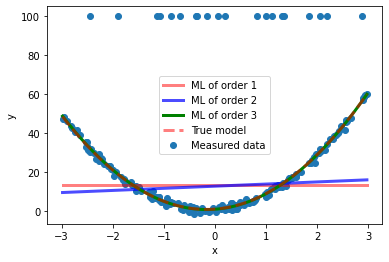

In [174]:
estimate1 = MLEfunction(1, laplace.pdf)
estimate2 = MLEfunction(2, laplace.pdf)
estimate3 = MLEfunction(3, laplace.pdf)

print(f"\nTrue model parameters: {true_params}")

# Plot measured data
plt.scatter(u, y, label=r"Measured data")
u0 = np.linspace(min(u), max(u), N)
plt.plot(u0, estimate1(u0), "r", alpha=0.5, lw=3, label="ML of order 1")
plt.plot(u0, estimate2(u0), "b", alpha=0.7, lw=3, label="ML of order 2")
plt.plot(u0, estimate3(u0), "g", alpha=1, lw=3, label="ML of order 3")
plt.plot(u0, y_model(u0), "r--", alpha = 0.5, lw = 3, label="True model")
plt.legend()
plt.xlabel("x")

plt.ylabel("y");